In [2]:
import numpy as np
from feos.si import *
from feos.uvtheory import UVParameters, Perturbation
from feos.pets import PetsParameters
from feos.eos import State, PhaseEquilibrium, PhaseDiagram, EquationOfState, Contributions
import matplotlib.pyplot as plt

**Thol EoS for Comparison**

In [15]:
# Parameters for Thol EoS:
A = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0,
              2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0])
N = np.array([0.005208073, 2.186252000, -2.161016000, 1.452700000, -2.041792000, 0.186952860, -0.090988445, 
              -0.497456100, 0.109014310, -0.800559220, -0.568839000, -0.620862500, -1.466717700, 1.891469000, 
              -0.138370100, -0.386964500, 0.126570200, 0.605781000, 1.179189000, -0.477326790, -9.921857500, -0.574793200, 0.003772923])
T = np.array([1.000, 0.320, 0.505, 0.672, 0.843, 0.898, 1.294, 2.590, 1.786, 2.770, 1.786,
              1.205, 2.830, 2.548, 4.650, 1.385, 1.460, 1.351, 0.660, 1.496, 1.830, 1.616, 4.970])
D = np.array([4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 5.0, 2.0, 2.0, 3.0, 1.0,
              1.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0, 1.0, 2.0, 3.0, 1.0, 1.0])
L = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0,
              1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
ETA = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.067, 1.522,
                8.82, 1.722, 0.679, 1.883, 3.925, 2.461, 28.2, 0.753, 0.82])
BETA = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.625,
                 0.638, 3.91, 0.156, 0.157, 0.153, 1.16, 1.73, 383, 0.112, 0.119])
GAMMA = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.71,
                  0.86, 1.94, 1.48, 1.49, 1.945, 3.02, 1.11, 1.17, 1.33, 0.24])
EPSILON = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2053,
                    0.409, 0.6, 1.203, 1.829, 1.397, 1.39, 0.539, 0.934, 2.369, 2.43])

class Thol:
    def __init__(self, sigma, eps_k):
        self.sigma = sigma * ANGSTROM
        self.eps_k = eps_k * KELVIN
        self.tc = 1.32 * self.eps_k / KELVIN
        self.rhoc = 0.31 / self.sigma**3 * ANGSTROM**3
        
    def components(self): 
        return 1
    
    def subset(self, components):
        return self
        
    def molar_weight(self):
        return np.array([1.0])
    
    def max_density(self, moles):
        return 0.04
    
    def helmholtz_energy(self, state):
        """
        state (StateHD):
            temperature in Kelvin als Float, Dual oder HD oder HD3, HDD, HDD3,
            partial_density in # / Angstrom^3
            volume in Angstrom^3
            moles in mol
        """
        tau = self.tc / state.temperature
        delta = np.sum(state.partial_density) / self.rhoc
        a = 0.0 #zero(state)
        
       # print("v", state.volume)
       # print("n", state.moles)
        #print("partial density", state.partial_density)
        #print("1")
       # print("delta: {}".format(delta))
      #  print("tau: {}".format(tau))
        
        for i in range(6):
            a = a + N[i] * delta**D[i] * tau**T[i]
        
       # print("2")
        for i in range(6, 12):
            a = a + N[i] * delta**D[i] * tau**T[i] * np.exp(-1.0 * delta**L[i])
       # print("3")
        for i in range(12, 23):
            a = a + N[i] * delta**D[i] * tau**T[i] * np.exp(- 1.0 * ETA[i] * (delta - EPSILON[i])**2.0 - 1.0 * BETA[i] * (tau - 1.0 * GAMMA[i])**2.0)
        return a * np.sum(state.moles)

---

**Class for dimensionless evaluation of LJ / Mie EoS**

In [24]:
class EOS_PROPERTIES():
    def __init__(self, eos, sigma=3.7039, eps_k=150.03,  rep=12, att=6.0):
        """Python class for the dimensionless evaluation of pure Mie-nu-6 EoS
            Input:  EquationOfState from feos,
                    Optional: diameter sigma, eps / kB, repulsive exponent rep, attractive exponent att
        """
        self.sigma = sigma
        self.nu = rep
        self.eps_k = eps_k
        self.eos = eos     
        
    def eos_state(self, temp, rho): 
                temperature = temp * self.eps_k * KELVIN
                density = rho / (self.sigma**3 * ANGSTROM**3 * NAV)
                return State(self.eos, temperature=temperature,  density=density) 
            
    ##### dimensionless quantities ###########
    def res_helmholtz_energy(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return self.eos_state(temp, rho).helmholtz_energy(Contributions.ResidualNvt) / (KB * temperature)
    
    def tot_helmholtz_energy(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return self.eos_state(temp, rho).helmholtz_energy() / (KB * temperature)
    
    def internal_energy(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return self.eos_state(temp, rho).internal_energy(Contributions.ResidualNvt) / (KB * temperature) * temp
    
    def chemical_potential(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return (self.eos_state(temp, rho).chemical_potential(Contributions.ResidualNvt) / RGAS / temperature)[0] * temp
    
    def total_pressure(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        p_vec = self.eos_state(temp, rho).pressure() * (self.sigma)**3 * ANGSTROM**3 /(KB * temperature) * temp
        return p_vec
    
    def residual_pressure(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        p_vec = self.eos_state(temp, rho).pressure(Contributions.ResidualNvt) * (self.sigma)**3 * ANGSTROM**3 /(KB * temperature) * temp
        return p_vec
    
    def heat_capacity_cv(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return self.eos_state(temp, rho).c_v(Contributions.ResidualNvt) / (RGAS) + 3.0 / 2.0  ## total
    
    def heat_capacity_cp(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return self.eos_state(temp, rho).c_p(Contributions.ResidualNvt) / (RGAS) + 5.0 / 2.0
    
    def compressibility(self, rho, temp):
        return self.eos_state(temp, rho).compressibility()
    
    def isothermal_compressibility(self, rho, temp):  # beta_t = 1 / rho*(dp/drho)
        return -1.0 / (self.eos_state(temp, rho).dp_dv() / self.eos_state(temp, rho).density) * KB * self.eps_k * KELVIN * NAV / (self.sigma**3 * ANGSTROM**3)
   
    def thermal_pressure_coefficient(self, rho, temp):
        return self.eos_state(temp, rho).dp_dt() /  KB * self.sigma**3 * ANGSTROM**3
    
    def thermal_expansion_coefficient(self, rho, temp):
        return self.thermal_pressure_coefficient(rho, temp) * self.isothermal_compressibility(rho, temp)
    
    def isotropic_compressibility(self, rho, temp):
        return self.eos_state(temp, rho).isentropic_compressibility() * self.eps_k * KELVIN * KB / (self.sigma**3 * ANGSTROM**3)
    
    def speed_of_sound(self, rho, temp):  
        return (self.heat_capacity_cp(rho, temp) / self.heat_capacity_cv(rho, temp) / rho / self.isothermal_compressibility(rho, temp))**0.5
        
    
    def joule_thomson(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return (self.isothermal_compressibility(rho, temp) * self.thermal_pressure_coefficient(rho, temp) * temp - 1.0) / (rho * self.heat_capacity_cp(rho, temp))
    
    def grueneisen_parameter(self, rho, temp):
        return self.eos_state(temp, rho).dp_dt() / (rho * self.heat_capacity_cv(rho, temp)) /  KB * self.sigma**3 * ANGSTROM**3
    
    def enthalpy(self, rho, temp):
        return  self.eos_state(temp, rho).enthalpy() / (KB * self.eps_k * KELVIN) 
    
    ############ Virial coefficients ###############################
    def second_virial_coefficient(self, temp):
        temperature = temp * self.eps_k * KELVIN
        return self.eos.second_virial_coefficient(temperature) / (self.sigma**3 * ANGSTROM**3 * NAV)
    
    def third_virial_coefficient(self, temp):  # Recheck!
        temperature = temp * self.eps_k * KELVIN
        return  self.eos.third_virial_coefficient(temperature)  / (self.sigma**3 * ANGSTROM**3 * NAV)**2 
    
    ##### VLE #####
    def vapor_pressure(self, temp):
        temperature = temp * self.eps_k * KELVIN
        vle = PhaseEquilibrium.pure(self.eos, temperature)
        return vle.vapor_pressure(self.eos, temperature)[0] * self.sigma**3 * ANGSTROM**3 / (self.eps_k * KELVIN * KB)
    
    def critical_point(self, initial_temp = 340*KELVIN ):
        return State.critical_point(self.eos, initial_temperature=initial_temp)
    
    def critical_pressure(self):
        return State.critical_point(self.eos, initial_temperature=100*KELVIN).pressure() * self.sigma**3 * ANGSTROM**3 / (self.eps_k * KELVIN * KB)
    
    def critical_density(self):
        return self.critical_point().density * (self.sigma**3 * ANGSTROM**3 * NAV)
    
    def critical_temperature(self):
        return self.critical_point().temperature / (self.eps_k * KELVIN)
    
    def vle_pressure(self, p):
        return PhaseEquilibrium.pure_p(self.eos, p * BAR)
    
    def vle_pressure_temperature(self, p):
        return PhaseEquilibrium.pure_p(self.eos, p * BAR).temperature / (self.eps_k * KELVIN)
    
    def vle_pressure_density(self, p):
        return PhaseEquilibrium.pure_p(self.eos, p * BAR).vapor.density * (self.sigma**3 * ANGSTROM**3 * NAV), VLEState.pure_p(self.eos, p * BAR).liquid.density * (self.sigma**3 * ANGSTROM**3 * NAV)
    
    def vle_temperature(self, temp):
        temperature = temp * self.eps_k * KELVIN
        return PhaseEquilibrium.pure_t(self.eos, temperature)
    
    def vle_temperature_dimensionless(self, temp):
        vle = self.vle_temperature(temp)
        return vle.vapor.density * (self.sigma**3 * ANGSTROM**3 * NAV), vle.liquid.density * (self.sigma**3 * ANGSTROM**3 * NAV)
    
    def vapor_density(self, temp):
        temperature = temp * self.eps_k * KELVIN
        vle = PhaseEquilibrium.pure(self.eos, temperature)
        return vle.vapor.density * (self.sigma**3 * ANGSTROM**3 * NAV)
    
    def liquid_density(self, temp):
        temperature = temp * self.eps_k * KELVIN
        vle = PhaseEquilibrium.pure(self.eos, temperature)
        return vle.liquid.density * (self.sigma**3 * ANGSTROM**3 * NAV)
    
    def enthalpy_of_vaporization(self, temp):
        temperature = temp * self.eps_k * KELVIN
        hv = self.enthalpy(self.vapor_density(temp), temp)
        hl = self.enthalpy(self.liquid_density(temp), temp)
        dhv = hv - hl
        return dhv


---

In [35]:
def get_eos(name,  rep, sigma = 3.7039, eps_k = 150.03, att=6.0):
    nu = rep
            
    if name == 'thol':
        eos = EquationOfState.python(Thol(sigma, eps_k))
        
    if name == 'uv_wca':
        parameters = UVParameters.from_lists([rep], [att], [sigma], [eps_k])
        eos = EquationOfState.uvtheory(parameters, perturbation=Perturbation.WeeksChandlerAndersen)
        
    if name == 'uv_bh':
        parameters = UVParameters.from_lists([nu], [rep], [sigma], [eps_k])
        eos = EquationOfState.uvtheory(parameters, perturbation=Perturbation.BarkerHenderson) 

    if name == 'uv_b3':
        parameters = UVParameters.from_lists([nu], [rep], [sigma], [eps_k], virial_order=VirialOrder.Third)
        eos = EquationOfState.uvb3(parameters)
        
        
    return EOS_PROPERTIES(eos, sigma=sigma, eps_k=eps_k, rep=rep, att=att)
    

In [36]:
rep = 12
att = 6
sigma = 3.7039 # in Angstrom
eps_k = 150.03 # eps / kB in K
thol = get_eos('thol', rep, sigma, eps_k, att)
uv_bh = get_eos('uv_bh', rep, sigma, eps_k, att)
uv_wca = get_eos('uv_wca', rep, sigma, eps_k, att)
uv_b3 =  get_eos('uv_b3', rep, sigma, eps_k, att)

NameError: name 'VirialOrder' is not defined

In [28]:
rho = 1.0
temp = 5
thol.res_helmholtz_energy(rho, temp)

2.1384039006646205

---

In [3]:
sigma = 3.7039
sigma_a = sigma * ANGSTROM
eps_k = 150.03
eps_k_k = eps_k * KELVIN

parameters = UVParameters.from_lists([12.0], [6.0], [sigma], [eps_k])
uvtheory_wca = EquationOfState.uvtheory(parameters)
uvtheory_bh = EquationOfState.uvtheory(parameters, perturbation=Perturbation.BarkerHenderson)

parameters = PetsParameters.from_values(sigma, eps_k)
pets = EquationOfState.pets(parameters)

thol = EquationOfState.python(Thol())
s3 = State(thol, temperature=300*KELVIN, pressure=1*BAR)

In [7]:
s1 = State(uvtheory_wca, temperature=300*KELVIN, pressure=1*BAR)
s2 = State(pets, temperature=300*KELVIN, pressure=1*BAR)
s3 = State(thol, temperature=300*KELVIN, pressure=1*BAR)

In [8]:
s1.molar_helmholtz_energy(Contributions.ResidualNvt) / (RGAS * 300 * KELVIN)

-0.0016213224956115704

In [9]:
s2.molar_helmholtz_energy(Contributions.ResidualNvt) / (RGAS * 300 * KELVIN)

-0.0009407040108813868

In [10]:
s3.molar_helmholtz_energy(Contributions.ResidualNvt) / (RGAS * 300 * KELVIN)

-0.0016144150962601586

In [11]:
State.critical_point(thol).temperature / eps_k_k, State.critical_point(uvtheory_wca).temperature / eps_k_k, State.critical_point(uvtheory_bh).temperature / eps_k_k

(1.3200003469821506, 1.3097658041494302, 1.3208296613277393)

In [12]:
%%time
vle_uv = PhaseDiagram.pure(uvtheory_wca, 150*KELVIN, 500)

CPU times: user 52.5 ms, sys: 1.45 ms, total: 54 ms
Wall time: 54.2 ms


In [13]:
vle_uv.liquid

In [14]:
%%time
vle_uv_bh = PhaseDiagram.pure(uvtheory_bh, 150*KELVIN, 500)

CPU times: user 49 ms, sys: 1.77 ms, total: 50.7 ms
Wall time: 52.6 ms


In [15]:
%%time
vle_thol = PhaseDiagram.pure(thol, 150*KELVIN, 500)

/var/folders/3s/t93ws1md04qdbbq5d1jdz8640000gn/T/ipykernel_78968/174117960.py:65: RuntimeWarning: overflow encountered in exp
  a = a + N[i] * delta**D[i] * tau**T[i] * np.exp(-1.0 * delta**L[i])
/var/folders/3s/t93ws1md04qdbbq5d1jdz8640000gn/T/ipykernel_78968/174117960.py:65: RuntimeWarning: invalid value encountered in exp
  a = a + N[i] * delta**D[i] * tau**T[i] * np.exp(-1.0 * delta**L[i])
/var/folders/3s/t93ws1md04qdbbq5d1jdz8640000gn/T/ipykernel_78968/174117960.py:68: RuntimeWarning: overflow encountered in exp
  a = a + N[i] * delta**D[i] * tau**T[i] * np.exp(- 1.0 * ETA[i] * (delta - EPSILON[i])**2.0 - 1.0 * BETA[i] * (tau - 1.0 * GAMMA[i])**2.0)
/var/folders/3s/t93ws1md04qdbbq5d1jdz8640000gn/T/ipykernel_78968/174117960.py:68: RuntimeWarning: invalid value encountered in exp
  a = a + N[i] * delta**D[i] * tau**T[i] * np.exp(- 1.0 * ETA[i] * (delta - EPSILON[i])**2.0 - 1.0 * BETA[i] * (tau - 1.0 * GAMMA[i])**2.0)


CPU times: user 1.9 s, sys: 16.4 ms, total: 1.92 s
Wall time: 1.93 s


In [16]:
%%time
vle_pets = PhaseDiagram.pure(pets, 150*KELVIN, 500)

CPU times: user 27 ms, sys: 1.68 ms, total: 28.7 ms
Wall time: 32.6 ms


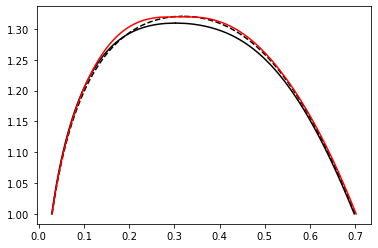

In [17]:
s3 = NAV * sigma_a**3
plt.plot(vle_uv.vapor.density * s3 , vle_uv.vapor.temperature / eps_k_k, color='black')
plt.plot(vle_uv.liquid.density * s3, vle_uv.vapor.temperature / eps_k_k, color='black')

plt.plot(vle_uv_bh.vapor.density * s3 , vle_uv_bh.vapor.temperature / eps_k_k, color='black', linestyle='dashed')
plt.plot(vle_uv_bh.liquid.density * s3, vle_uv_bh.vapor.temperature / eps_k_k, color='black', linestyle='dashed')

plt.plot(vle_thol.vapor.density * s3, vle_thol.vapor.temperature / eps_k_k, color='red')
plt.plot(vle_thol.liquid.density * s3, vle_thol.vapor.temperature / eps_k_k, color='red')

In [ ]:
vle_thol = PhaseDiagram.pure(thol, 150*KELVIN, 500)
s3 = NAV * sigma_a**3
plt.plot(vle_uv.vapor.density * s3 , vle_uv.vapor.temperature / eps_k_k, color='black')